## *INSTALL REQUIRED LIBRARIES*

In [1]:
# perform quiet  install 
!pip install -q pycaret >/dev/null 2>&1 # library used for model trainning and evaluation 
!pip install -q scipy


## *LIBRARIES*

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pickle



from pycaret.classification import *
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


sns.set_palette("pastel")

## *DATA READING*

In [3]:
original_df=pd.read_csv('/kaggle/input/hotel-reservation/Hotel  Dataset.csv')
df=original_df.copy()
df.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled


## *DATA DESCRIPTION*
* **Booking_ID** :unique identifier of each booking . <br>
* **number of adults** : Number of adults . <br>
* **number of children** : Number of Children . <br>
* **number of weekend nights** : Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel .<br>
* **number of week nights** : Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel . <br>
* **type of meal** : Type of meal plan booked by the customer. <br>
* **car_parking_space** : Does the customer require a car parking space? (0 - No, 1- Yes). <br>
* **room_type** : Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.<br>
* **lead_time** : Number of days between the date of booking and the arrival date . <br>
* **market segment type** : Where the booking came from . <br>
* **repeated** : Is the customer a repeated guest? (0 - No, 1- Yes) .<br>
* **P-C** : Number of previous bookings that were canceled by the customer prior to the current booking .<br>
* **P-not-C** : Number of previous bookings not canceled by the customer prior to the current booking .<br>
* **average price** : Average price per day of the reservation; prices of the rooms are dynamic. (in euros) .<br>
* **special requests** : Total number of special requests made by the customer (e.g. high floor, view from the room, etc) .<br>
* **date of reservation** : Date of the month
* **booking status** : Flag indicating if the booking was canceled or not.<br>

========================================================================================

* **continuous features [lead_time,average Price]** 
* **other features are discrete**

## *DATA PREPOSSESING & EDA*
* **MAKE SURE WE HAVE THE PROPER DATA TYPE**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36285 entries, 0 to 36284
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Booking_ID                36285 non-null  object 
 1   number of adults          36285 non-null  int64  
 2   number of children        36285 non-null  int64  
 3   number of weekend nights  36285 non-null  int64  
 4   number of week nights     36285 non-null  int64  
 5   type of meal              36285 non-null  object 
 6   car parking space         36285 non-null  int64  
 7   room type                 36285 non-null  object 
 8   lead time                 36285 non-null  int64  
 9   market segment type       36285 non-null  object 
 10  repeated                  36285 non-null  int64  
 11  P-C                       36285 non-null  int64  
 12  P-not-C                   36285 non-null  int64  
 13  average price             36285 non-null  float64
 14  specia

* **NOTE <br>'date of reservation' data type is object we need to change it**<br>


### *SUMMARY STATISTICS*

In [5]:
describe=df.describe().T
describe['nunique']=df.nunique()
describe['NULLS']=df.isna().sum()
describe

,count,mean,std,min,25%,50%,75%,max,nunique,NULLS
number of adults,36285.0,1.844839,0.518813,0.0,2.0,2.00,2.0,4.0,5,0
number of children,36285.0,0.105360,0.402704,0.0,0.0,0.00,0.0,10.0,6,0
number of weekend nights,36285.0,0.810693,0.870590,0.0,0.0,1.00,2.0,7.0,8,0
number of week nights,36285.0,2.204602,1.410946,0.0,1.0,2.00,3.0,17.0,18,0
car parking space,36285.0,0.030977,0.173258,0.0,0.0,0.00,0.0,1.0,2,0
lead time,36285.0,85.239851,85.938796,0.0,17.0,57.00,126.0,443.0,352,0
repeated,36285.0,0.025630,0.158032,0.0,0.0,0.00,0.0,1.0,2,0
P-C,36285.0,0.023343,0.368281,0.0,0.0,0.00,0.0,13.0,9,0
P-not-C,36285.0,0.153369,1.753931,0.0,0.0,0.00,0.0,58.0,59,0
average price,36285.0,103.421636,35.086469,0.0,80.3,99.45,120.0,540.0,3930,0


### *MISSING DATA*

In [6]:
df.isna().sum().sum()

0

### *DROP HIGH CARDINALITY FEATURES*

In [7]:
df.drop('Booking_ID',axis=1,inplace=True)

###  *DATE COLUMN HANDLING*

In [8]:
#there is natural outliers In the date column 
#we notice that we have “2-29-2018” but in 2018 there is no 2/29
df['date of reservation'] = df['date of reservation'].replace('2018-2-29','3/1/2018')
# split the date col
df['month']=(df['date of reservation'].str.split('/',expand=True)[0]).astype(int)
df['day']=df['date of reservation'].str.split('/',expand=True)[1].astype(int)
df['year']=df['date of reservation'].str.split('/',expand=True)[2].astype(int)

# drop old date col
df.drop('date of reservation',axis=1,inplace=True)

In [9]:
continuous_cols=['lead time','average price ']

discrete_cols=['number of adults', 'number of children', 'number of weekend nights',
       'number of week nights', 'type of meal', 'car parking space',
       'room type',  'market segment type', 'repeated', 'P-C','month','year','P-not-C',
        'special requests']

## *VISUALIZING AND HANDLING DATA FOR EACH FEATURE*

#### *CONTINUOUS FEATURES*
#### *VISUALIZING  LEAD TIME*


Text(0.5, 1.0, 'BOXPLOT FOR lead time')

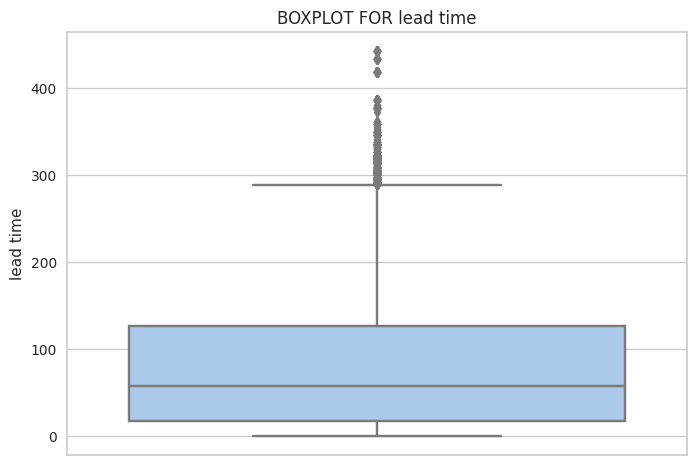

In [10]:
col=continuous_cols[0]
sns.boxplot(y=df[col])
plt.title(f'BOXPLOT FOR {col}')

#### *DROP OUTLIERS*

In [11]:
Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1
outliers = (df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)
df = df[~outliers]

#### *VISUALIZING  AVERAGE PRICE*

Text(0.5, 1.0, 'BOXPLOT FOR average price ')

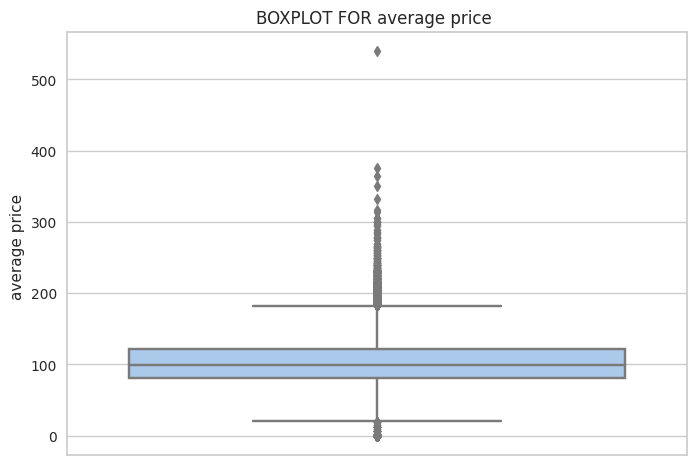

In [12]:
col=continuous_cols[1]
sns.boxplot(y=df[col])
plt.title(f'BOXPLOT FOR {col}')

#### *DROP OUTLIERS*

In [13]:
Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1
outliers = (df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)
df = df[~outliers]


#### *DISCRETE FEATURES*

#### *VISUALIZING  NUMBER OF ADULTS*

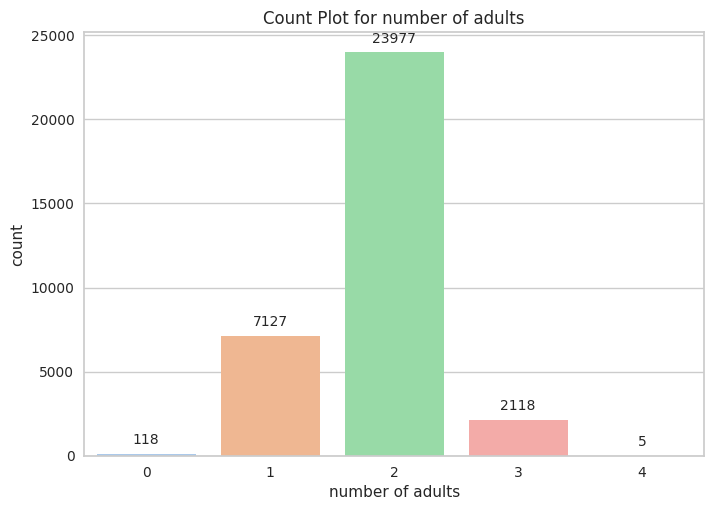

In [14]:
col = discrete_cols[0]


sns.countplot(x=df[col])


for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

plt.title(f'Count Plot for {col}')
plt.show()


#### COMBINE INFREQUENT OR UNEXPECTED VALUES

In [15]:
replace_dict={0:'other',1:'1',2:'2',3:'3',4:'other',5:'other',6:'other'}
df[col] = df[col].replace(replace_dict)

#### *VISUALIZING  NUMBER OF CHILDREN*

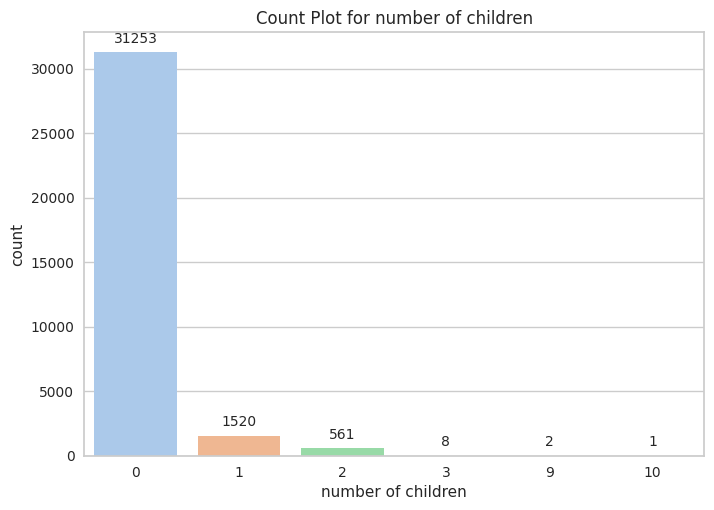

In [16]:
col = discrete_cols[1]

sns.countplot(x=df[col])

for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

plt.title(f'Count Plot for {col}')
plt.show()

#### COMBINE INFREQUENT OR UNEXPECTED VALUES

In [17]:
replace_dict={0:'0',1:'1',2:'2',3:'other',4:'other',5:'other',6:'other',7:'other',8:'other',9:'other'
              ,10:'other',11:'other',12:'other'}
df[col] = df[col].replace(replace_dict)

#### *VISUALIZING  NUMBER OF WEEKEND NIGHTS*

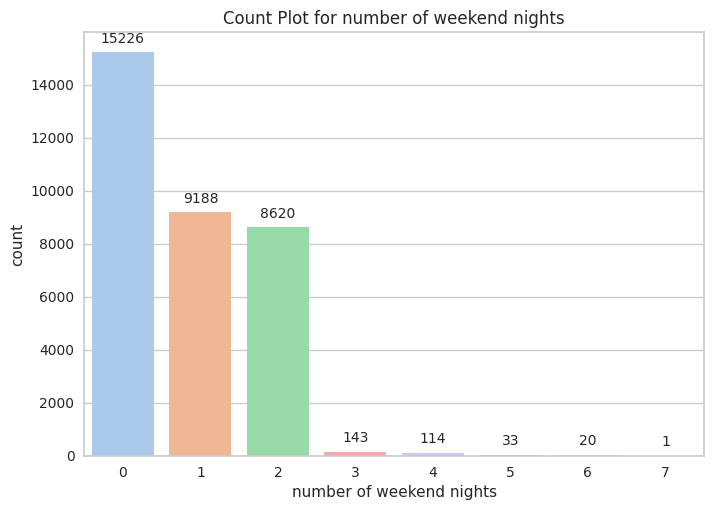

In [18]:

col = discrete_cols[2]


sns.countplot(x=df[col])


for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

plt.title(f'Count Plot for {col}')
plt.show()

#### COMBINE INFREQUENT OR UNEXPECTED VALUES

In [19]:
replace_dict={0:'0',1:'1',2:'2',3:'other',4:'other',5:'other',6:'other',7:'other',8:'other',9:'other'
              ,10:'other',11:'other',12:'other'}
df[col] = df[col].replace(replace_dict)

#### *VISUALIZING  NUMBER OF WEEK NIGHTS*

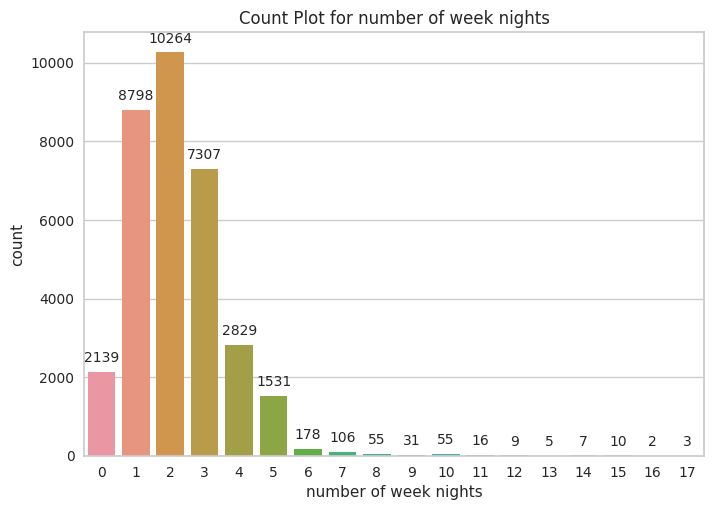

In [20]:

col = discrete_cols[3]


sns.countplot(x=df[col])


for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

plt.title(f'Count Plot for {col}')
plt.show()

#### COMBINE INFREQUENT OR UNEXPECTED VALUES

In [21]:
replace_dict={0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'other',7:'other',8:'other',9:'other'
              ,10:'other',11:'other',12:'other',13:'other',14:'other',15:'other'
             ,16:'other',17:'other',18:'other'}
df[col] = df[col].replace(replace_dict)

#### *VISUALIZING  MEAL TYPES*


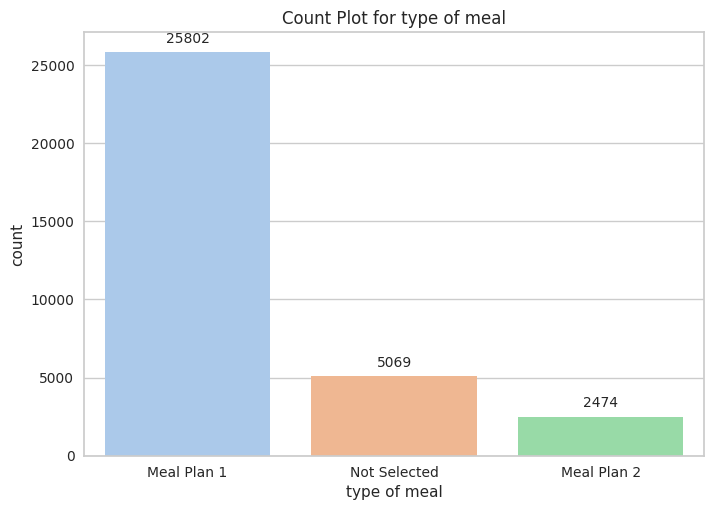

In [22]:

col = discrete_cols[4]


sns.countplot(x=df[col])


for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

plt.title(f'Count Plot for {col}')
plt.show()


#### *VISUALIZING  CAR PARKING SPACE*


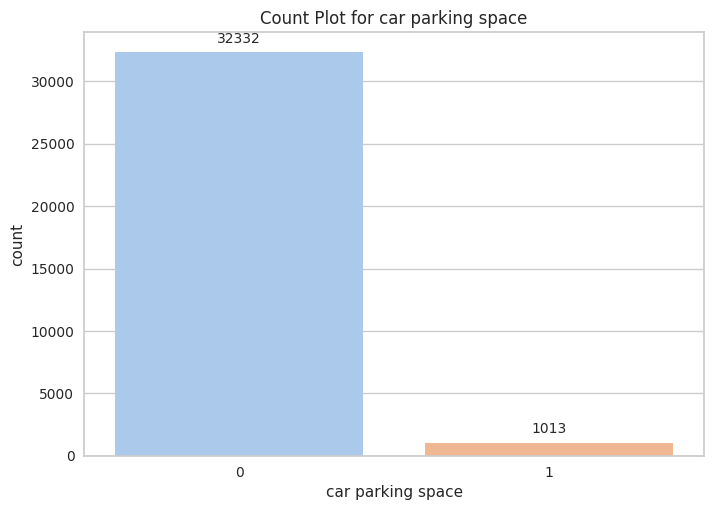

In [23]:

col = discrete_cols[5]


sns.countplot(x=df[col])


for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

plt.title(f'Count Plot for {col}')
plt.show()


#### *VISUALIZING  CAR ROOM TYPE*


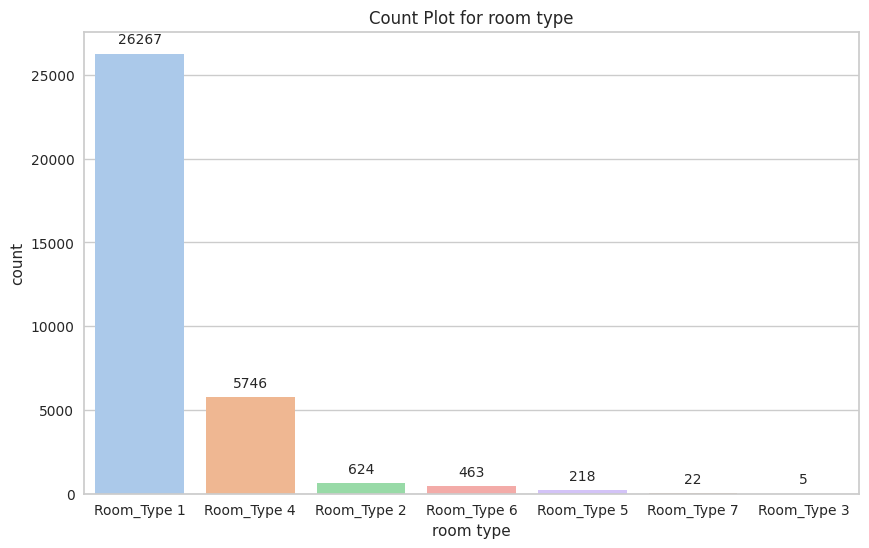

In [24]:

col = discrete_cols[6]
plt.figure(figsize=(10, 6))

sns.countplot(x=df[col])


for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

plt.title(f'Count Plot for {col}')
plt.show()

#### COMBINE INFREQUENT OR UNEXPECTED VALUES

In [25]:
replace_dict={'Room_Type 1':'1'  ,'Room_Type 2':'other','Room_Type 3':'other','Room_Type 4':'4','Room_Type 5':'other'
             ,'Room_Type 6':'other','Room_Type 7':'other'}

df[col] = df[col].replace(replace_dict)

#### *VISUALIZING  MARKET SEGMENT TYPE*


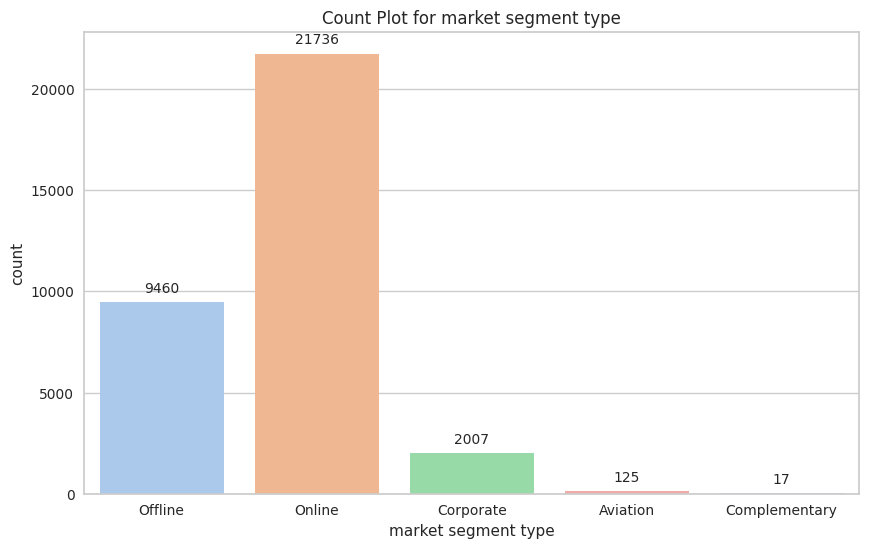

In [26]:
col = discrete_cols[7]
plt.figure(figsize=(10, 6))

sns.countplot(x=df[col])


for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

plt.title(f'Count Plot for {col}')
plt.show()

#### COMBINE INFREQUENT OR UNEXPECTED VALUES


In [27]:
replace_dict={'Corporate':'other'
             ,'Aviation':'other','Complementary':'other'}

df[col] = df[col].replace(replace_dict)

#### *VISUALIZING  REPEATED*


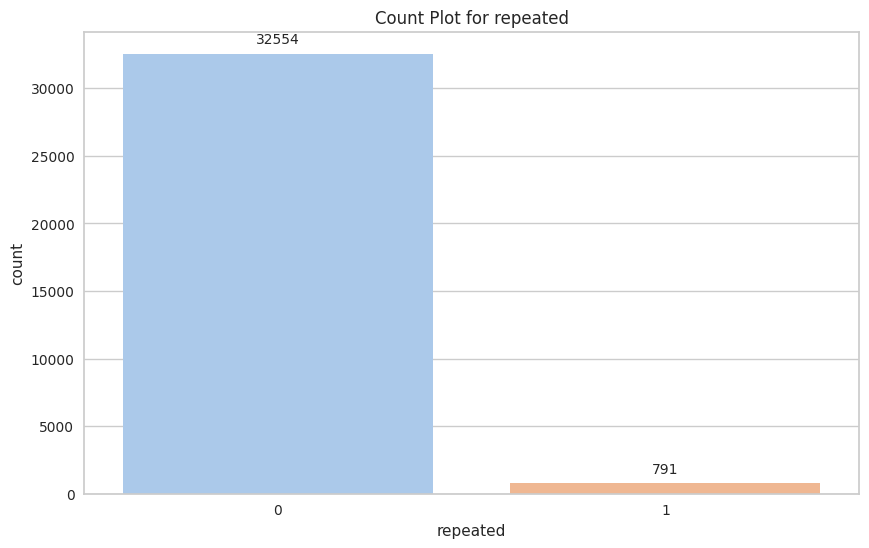

In [28]:
col = discrete_cols[8]
plt.figure(figsize=(10, 6))

sns.countplot(x=df[col])


for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

plt.title(f'Count Plot for {col}')
plt.show()

#### *VISUALIZING  P-C*


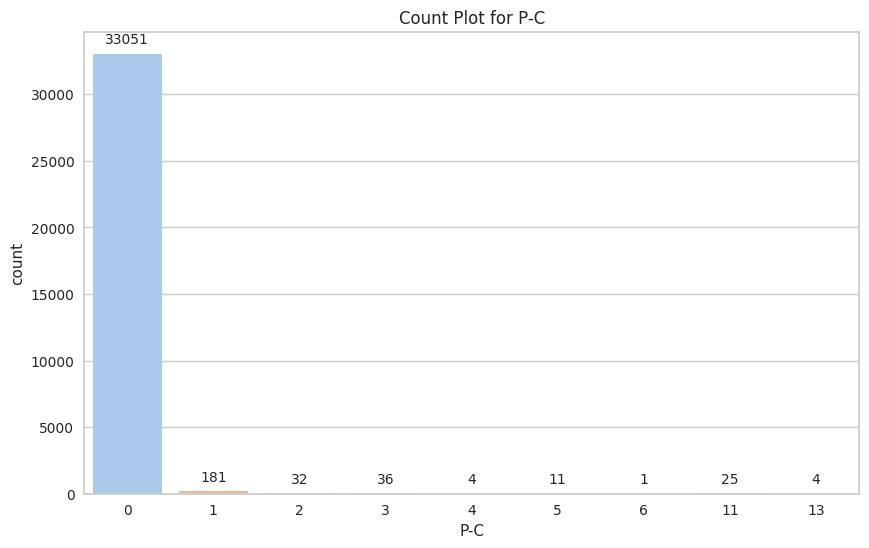

In [29]:
col = discrete_cols[9]
plt.figure(figsize=(10, 6))

sns.countplot(x=df[col])


for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

plt.title(f'Count Plot for {col}')
plt.show()

#### COMBINE INFREQUENT OR UNEXPECTED VALUES


In [30]:
replace_dict={0:'NO',1:'YES',2:'YES',3:'YES',4:'YES',5:'YES',6:'YES',11:'YES',13:'YES'}
df[col] = df[col].replace(replace_dict)


#### *VISUALIZING  MONTH*

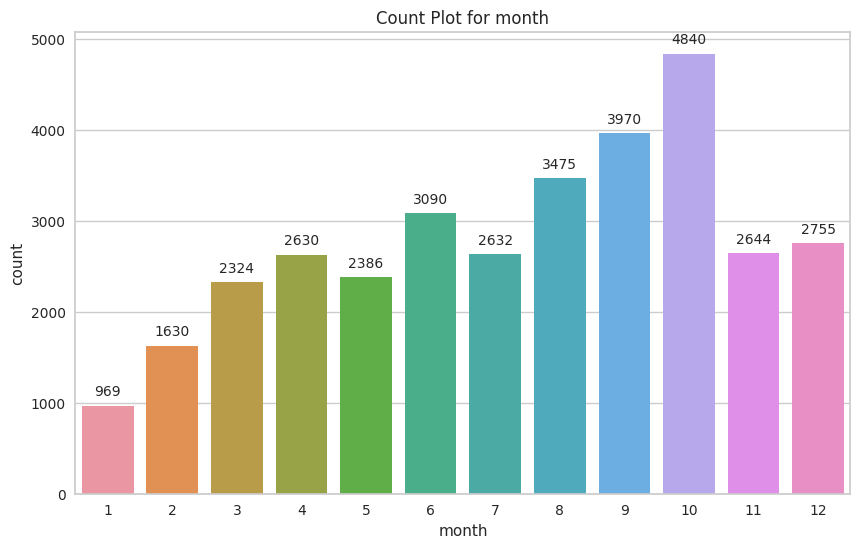

In [31]:

col = discrete_cols[10]
plt.figure(figsize=(10, 6))

sns.countplot(x=df[col])


for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

plt.title(f'Count Plot for {col}')
plt.show()

#### *VISUALIZING  YEAR*

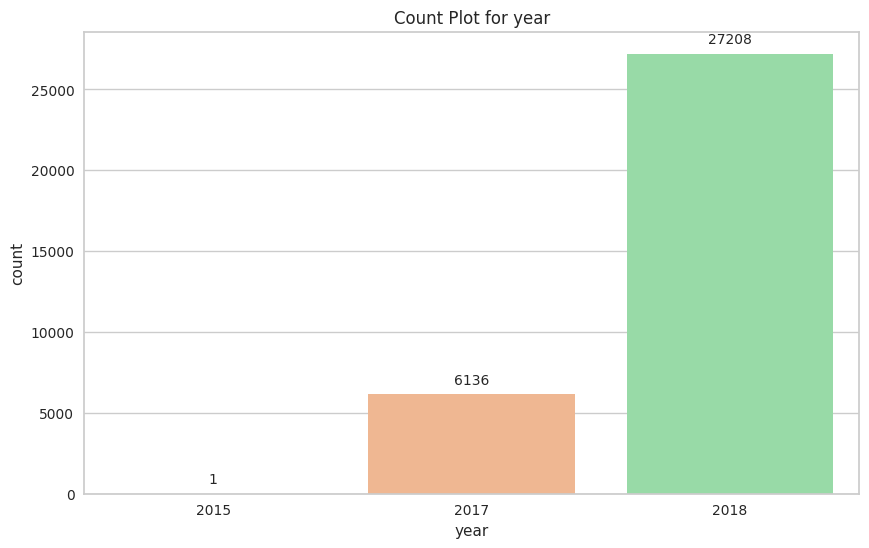

In [32]:

col = discrete_cols[11]
plt.figure(figsize=(10, 6))

sns.countplot(x=df[col])


for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

plt.title(f'Count Plot for {col}')
plt.show()

#### DROP INFREQUENT OR UNEXPECTED VALUES


In [33]:
indices=df[(df[col].isin([2015]))].index
df.drop(indices,axis=0,inplace=True)

#### *VISUALIZING  P_ NOT _C*

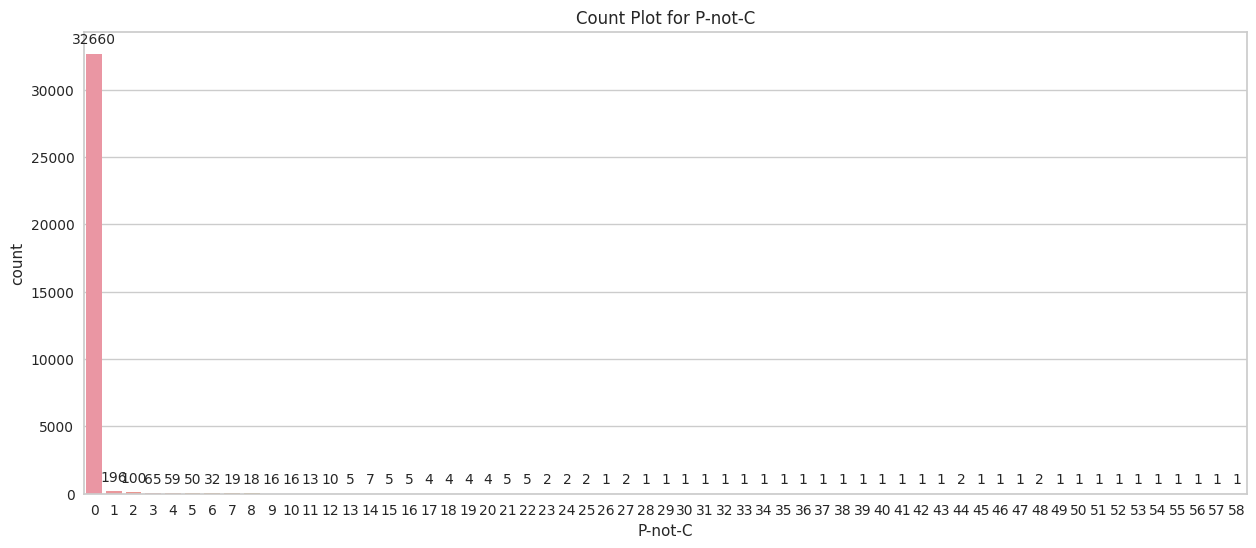

In [34]:

col = discrete_cols[12]
plt.figure(figsize=(15, 6))

sns.countplot(x=df[col])


for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

plt.title(f'Count Plot for {col}')
plt.show()

#### COMBINE INFREQUENT OR UNEXPECTED VALUES


In [35]:
replace_dict={0:'YES'  ,5:'NO',  3:'NO',  1:'NO', 12:'NO', 19:'NO',  2:'NO', 15:'NO', 17:'NO',  4:'NO', 13:'NO',  6:'NO'
              , 14:'NO', 34:'NO', 18:'NO', 16:'NO',  8:'NO',10:'NO', 23:'NO', 11:'NO', 49:'NO', 47:'NO', 53:'NO',  7:'NO',
              9:'NO', 33:'NO', 22:'NO', 24:'NO', 52:'NO', 21:'NO', 48:'NO', 28:'NO', 39:'NO', 20:'NO',38:'NO', 26:'NO',
              51:'NO', 42:'NO', 37:'NO', 35:'NO', 56:'NO', 44:'NO', 27:'NO', 55:'NO', 45:'NO', 30:'NO', 57:'NO', 31:'NO'
              , 54:'NO', 43:'NO', 58:'NO',41:'NO', 29:'NO', 40:'NO', 36:'NO', 32:'NO',50:'NO', 25:'NO', 46:'NO' }
df[col] = df[col].replace(replace_dict)


#### *VISUALIZING  SPECIAL REQUESTS*

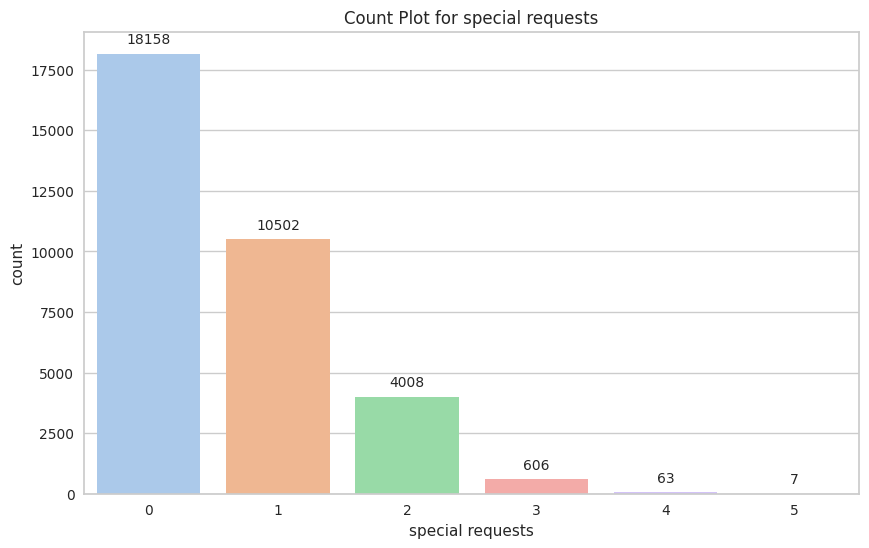

In [36]:

col = discrete_cols[13]
plt.figure(figsize=(10, 6))

sns.countplot(x=df[col])


for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

plt.title(f'Count Plot for {col}')
plt.show()

#### COMBINE INFREQUENT OR UNEXPECTED VALUES


In [37]:
replace_dict={0:'0'  ,1:'1',  2:'2',  3:'other', 4:'other',5:'other'}
df[col] = df[col].replace(replace_dict)

#### *VISUALIZING  DAY*

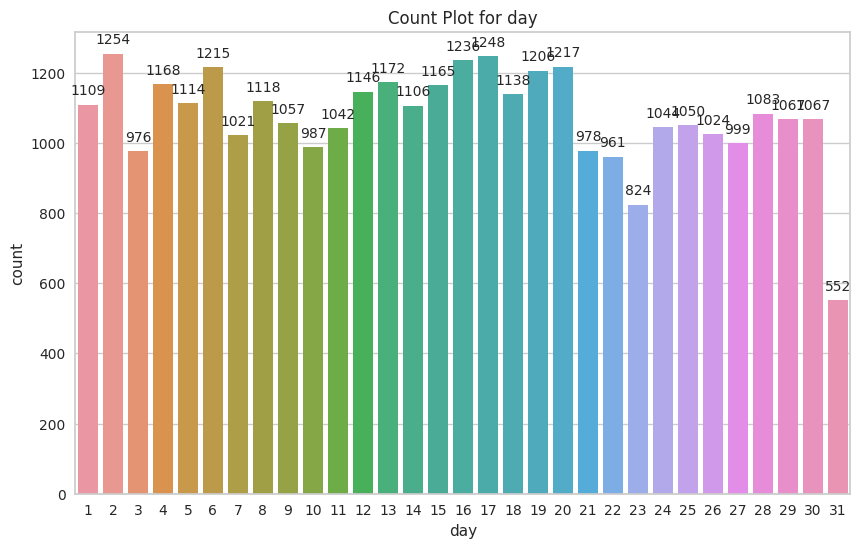

In [38]:
col = 'day'
plt.figure(figsize=(10, 6))

sns.countplot(x=df[col])


for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

plt.title(f'Count Plot for {col}')
plt.show()

## *FEATURE ENCODING*

In [39]:
for col in df.columns:
    print(f'{col}')
    print(df[col].unique())
    print('='*75)

number of adults
['1' '2' '3' 'other']
number of children
['0' '1' '2' 'other']
number of weekend nights
['1' '0' '2' 'other']
number of week nights
['3' '2' '4' '5' '0' '1' 'other']
type of meal
['Not Selected' 'Meal Plan 1' 'Meal Plan 2']
car parking space
[0 1]
room type
['1' '4' 'other']
lead time
[  5   1 211  48  34  83 121  44   0  35  30  95  47 256  99  12 122   2
  37 130  60  56   3 107  72  23 289 247 186  64  96  41  55 146  32  57
   7 124 169   6  51  13 100 139 117  39  86  19 192 179  26  74 143 177
  18 267 155  46 128  20  40 196 188  17 110  68  73  92 171 134 118 189
  16  24   8  10 182 123 105 286 148  14  85  25  28  80  11 162  82  27
 245 266 112  88  69 273   4  97  31  62 197 280 185 160 104  22 109 126
  81  54  15 161 147  87 127 156  58 111 195 119  59  78 103  70  76 144
  49  77  36  79  21  33 164 152  43 102  71 209  93  53 239  45 167 113
 166 174  61 151  52  84  67 282  38 175  89 133  65  66  50 159 115 237
 125  91  29 221 213 198  75 180 224 236

In [40]:
hot=['number of adults', 'number of children', 'number of weekend nights',
       'number of week nights', 'type of meal', 'car parking space',
       'room type', 'market segment type', 'repeated', 'P-C',
       'P-not-C', 'special requests']
df=pd.get_dummies(columns=hot,data=df)
df['booking status']=df['booking status'].replace({'Not_Canceled':0 ,'Canceled':1})


## *DATA SPLITTING* 

In [41]:
X = df.drop('booking status', axis=1)
y = df['booking status']

cols=X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#X_train.to_csv('before_scaling.csv')
# saving this to use in deployment to train scaler on it 

## *DATA SCALING* 

In [42]:
robust_scaler = RobustScaler()

X_train = robust_scaler.fit_transform(X_train)
X_test=robust_scaler.fit_transform(X_test)

## *MODELING*

#### *COMPARE BETWEEN MODELS TO SELECT THE BEST MODEL TO OPTMIZE IT*

In [43]:
data=pd.DataFrame(X_train,columns=cols)
data['target_variable']=y_train.values

clf1 = setup(data, target='target_variable',train_size=0.9,preprocess=False,session_id=8389)

compare_models(['rf','knn','lr','svm','dt'])


,Description,Value
0,Session id,8389
1,Target,target_variable
2,Target type,Binary
3,Original data shape,"(26675, 46)"
4,Transformed data shape,"(26675, 46)"
5,Transformed train set shape,"(24007, 46)"
6,Transformed test set shape,"(2668, 46)"
7,Numeric features,45


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8927,0.9444,0.7822,0.8623,0.8202,0.7441,0.7459,1.8220
dt,Decision Tree Classifier,0.8590,0.8405,0.7814,0.7714,0.7762,0.6733,0.6734,0.1000
knn,K Neighbors Classifier,0.8341,0.8802,0.7083,0.7483,0.7277,0.6086,0.6091,0.3840
lr,Logistic Regression,0.8076,0.8559,0.6078,0.7321,0.6640,0.5309,0.5355,0.2160
svm,SVM - Linear Kernel,0.8021,0.0000,0.6019,0.7207,0.6544,0.5176,0.5227,0.1450


Processing:   0%|          | 0/25 [00:00<?, ?it/s]

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=8389, verbose=0, warm_start=False)

In [44]:
# Create models for multiple algorithms
rf_model = create_model('rf', verbose=False)
knn_model = create_model('knn', verbose=False)
lr_model = create_model('lr', verbose=False)
svm_model = create_model('svm', verbose=False)
dt_model = create_model('dt', verbose=False)

# Evaluate the models
print ('RANDOM FOREST MODEL \n')
evaluate_model(rf_model)
print (' \n KNN MODEL')
evaluate_model(knn_model)
print (' \n LOGISTIC REGRESSION MODEL')
evaluate_model(lr_model)
print (' \n SVM MODEL')
evaluate_model(svm_model)
print (' \n DECISION TREE MODEL')
evaluate_model(dt_model)

RANDOM FOREST MODEL 



interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

 
 KNN MODEL


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

 
 LOGISTIC REGRESSION MODEL


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

 
 SVM MODEL


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

 
 DECISION TREE MODEL


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

#### *IT LOOKS LIKE WE GOT A WINNER WHICH IS RANDOM FOREST CLASSIFIER LETS TRY TO MAKE IT BETTER*

## *HYPER PARAMETER OPTIMIZATION*

##### FROM ABOVE COMPARISON WE FOUND THAT RANDOM FOREST CLASSIFIER IS THE BEST MODEL FOR THIS DATA SO I WIIL TRY TO MAKE IT BETTER USING PYCARET TUNE FUNCTION WHICH I WILL CUSTOMIZE IT TO WORK LIKE GRID SEARCH

In [45]:
param_grid = {"n_estimators" : [100,120,270, 400, 500],
              "max_depth": [20, 25, 30]
             }
tuned_model=tune_model(rf_model,custom_grid=param_grid,verbose=False)


#### *CHECK PARAMETERS AND EVALUATE THE MODEL*

In [46]:
tuned_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=-1, oob_score=False,
                       random_state=8389, verbose=0, warm_start=False)

In [47]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

#### *TEST THE MODEL ON TEST SET AND EVALUATE* 

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      4794
           1       0.78      0.86      0.82      1875

    accuracy                           0.89      6669
   macro avg       0.86      0.88      0.87      6669
weighted avg       0.90      0.89      0.89      6669



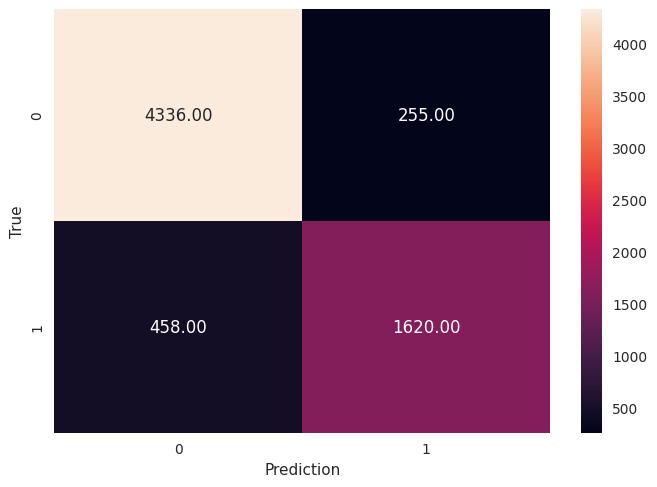

In [48]:
y_pred=tuned_model.predict(X_test)
print(classification_report(y_pred,y_test))
sns.heatmap(confusion_matrix(y_test, y_pred), annot= True, fmt=".2f")

plt.xlabel("Prediction")
plt.ylabel("True")

plt.show()

#### *CREATING THE MODEL USUAL WAY TO SAVE WITH PICKLE FOR DEPLOYMENT* 

              precision    recall  f1-score   support

           0       0.94      0.91      0.92      4781
           1       0.78      0.86      0.82      1888

    accuracy                           0.89      6669
   macro avg       0.86      0.88      0.87      6669
weighted avg       0.90      0.89      0.90      6669



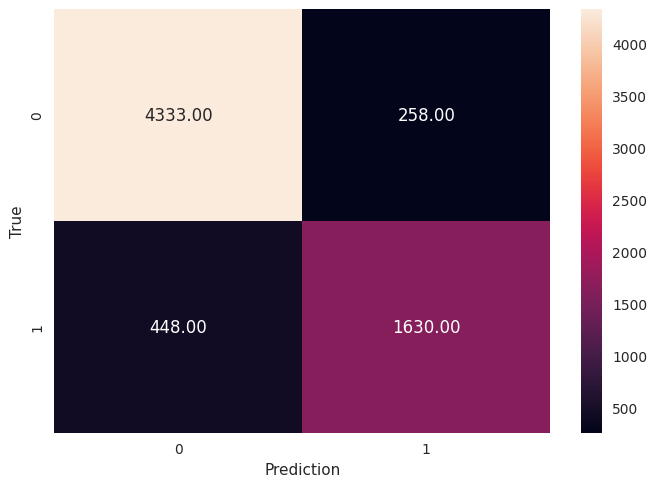

In [49]:
rf_model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=-1, oob_score=False,
                       random_state=8389, verbose=0, warm_start=False)
rf_model.fit(X_train, y_train)
y_pred=rf_model.predict(X_test)
print(classification_report(y_pred,y_test))
sns.heatmap(confusion_matrix(y_test, y_pred), annot= True, fmt=".2f")

plt.xlabel("Prediction")
plt.ylabel("True")

plt.show()

In [50]:
# with open('/kaggle/working/random_forest_model_pickle.pkl', 'wb') as model_file:
#     pickle.dump(rf_model ,model_file)